In [1]:
import logging
import numpy as np

from map_elites.mapelites import MapElites, FeatureDimension

logging.basicConfig(filename="log.log", level=logging.INFO)

In [2]:
class MapElitesContinuousOpt(MapElites):

    def __init__(self, *args, **kwargs):
        super(MapElitesContinuousOpt, self).__init__(*args, **kwargs)

    def map_x_to_b(self, x):
        """
        Map X solution to feature space dimension, meaning:
            - apply the constraints to a solution
        :return: tuple of indexes
        """
        b = tuple()
        for ft in self.feature_dimensions:
            desc = ft.feature_descriptor(x)
            i = ft.discretize(desc)
            b = b + (i,)

        return b

    def performance_measure(self, x):
        """
        Apply the fitness continuous function to x
        """
        logging.info("calculate performance measure")
        return self.F.evaluate(x)

    def generate_random_solution(self):
        """
        To ease the bootstrap of the algorithm, we can generate
        the first solutions in the feature space, so that we start
        filling the bins
        """
        logging.info("Generate random solution")

        dimensions = self.F.get_domain()
        return np.array([
            np.random.uniform(d[0], d[1], 1)[0] for d in dimensions
        ])

    def generate_feature_dimensions(self):

        # means the user is using contsraint-specific bins
        if 'bin_all' not in self.bins:
            n_constr = len(self.F.constraints().items())
            if len(self.bins.items()) != n_constr:
                raise ValueError(f"You need to define {n_constr} constraints for constrained function {self.F.__class__.__name__}")

            # check all the defined constraints match the function constraints names
            for k, v in self.bins.items():
                cst_name = k.split('_')[1]
                if cst_name not in self.F.constraints().keys():
                    raise ValueError(f"Constraint {cst_name} was not found in function {self.F.__class__.__name__}")

        fts = list()
        for k, v in self.F.constraints().items():
            bin_key = f"bin_{v['name']}"
            b = self.bins[bin_key] if bin_key in self.bins else self.bins['bin_all']
            ft = FeatureDimension(name=v['name'],
                                  feature_function_target=v['target'],
                                  feature_function_call=v['func'],
                                  feature_function_operator=v['op'],
                                  bins=b)
            fts.append(ft)
        return fts

Iterations completed: 100%|██████████| 10000/10000 [00:10<00:00, 922.86it/s]


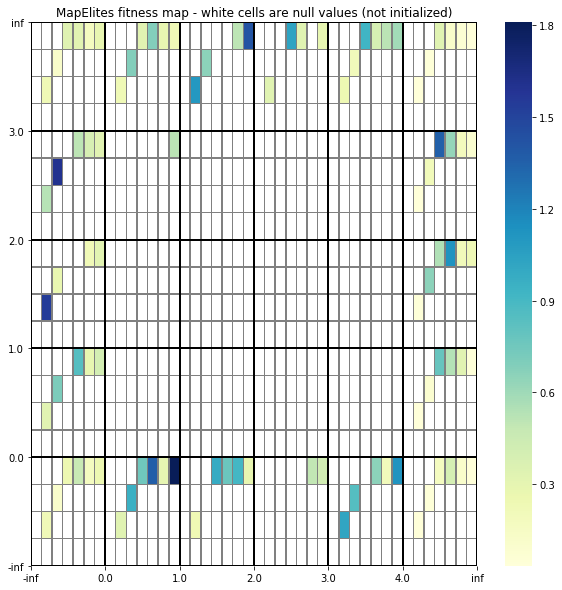

In [3]:
# path to configuration file
config_path = 'config.ini'
logging.info("Start map elites")
map_E = MapElitesContinuousOpt.from_config(config_path)
map_E.run()